In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import string
import requests
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def player_info():
    '''
    This function web scrapes basketball-reference and extracts player's info.
    '''
    players = []
    base_url = 'http://www.basketball-reference.com/players/'

    # get player tables from alphabetical list pages
    for letter in string.ascii_lowercase:
        page_request = requests.get(base_url + letter)
        soup = BeautifulSoup(page_request.text,"lxml")
        # find table in soup
        table = soup.find('table')

        if table:
            table_body = table.find('tbody')

            # loop over list of players
            for row in table_body.findAll('tr'):

                # get name and url
                player_url = row.find('a')
                player_names = player_url.text
                player_pages = player_url['href']

                # get some player's info from table
                cells = row.findAll('td')
                active_from = int(cells[0].text)
                active_to = int(cells[1].text)
                position = cells[2].text
                height = cells[3].text
                weight = cells[4].text
                birth_date = cells[5].text
                college = cells[6].text    

                # create entry
                player_entry = {'url': player_pages,
                                'name': player_names,
                                'active_from': active_from,
                                'active_to': active_to,
                                'position': position,
                                'college': college,
                                'height': height,
                                'weight': weight,
                                'birth_date': birth_date}

                # append player dictionary
                players.append(player_entry)
                
    return pd.DataFrame(players)

In [3]:
df = player_info()

In [4]:
# convert weight to integer
df['weight'] = pd.to_numeric(df['weight'], errors='coerce')

# convert height to inches
height_in_inches = df['height'].str.split('-',expand=True)
df['height_in_inches'] = 12.0*pd.to_numeric(height_in_inches[0], errors='coerce')+pd.to_numeric(height_in_inches[1], errors='coerce')

# calculate BMI for each player
df['BMI'] = (df['weight'].values/2.2)/(df['height_in_inches'].values*2.54/100)**2

In [5]:
df.describe()

,active_from,active_to,weight,height_in_inches,BMI
count,4660.000000,4660.000000,4654.000000,4659.000000,4654.000000
mean,1985.870601,1990.070815,209.071551,78.033698,24.112604
std,21.345717,22.203930,26.165492,3.635192,1.671333
min,1947.000000,1947.000000,114.000000,63.000000,17.015985
25%,1970.000000,1973.000000,190.000000,75.000000,23.104353
50%,1987.000000,1993.000000,210.000000,78.000000,23.998628
75%,2005.000000,2010.000000,225.000000,81.000000,25.060311
max,2019.000000,2019.000000,360.000000,91.000000,32.020814


In [6]:
BMI = []
h = []
w = []
for i in range(1947,2019):
    mask = (df.active_from.values <= i) & (df.active_to >= i) # only include active players
    BMI.append(np.mean(df[mask].BMI)) # average BMI 
    h.append(np.mean(df[mask].height_in_inches)) # average height in inches
    w.append(np.mean(df[mask].weight)) # average weight in pounds
    
# create a DataFrame with a summary
years = pd.DataFrame({'BMI': BMI, 'Season':  np.arange(1947,2019),
                     'weight': w, 'height': h}).set_index('Season')

# preview
years.head()

,BMI,weight,height
Season,,,
1947,24.017436,188.656250,74.322981
1948,23.682333,187.362832,74.570175
1949,23.826997,191.536723,75.197740
1950,23.734124,191.493274,75.324444
1951,23.800475,194.549020,75.843137


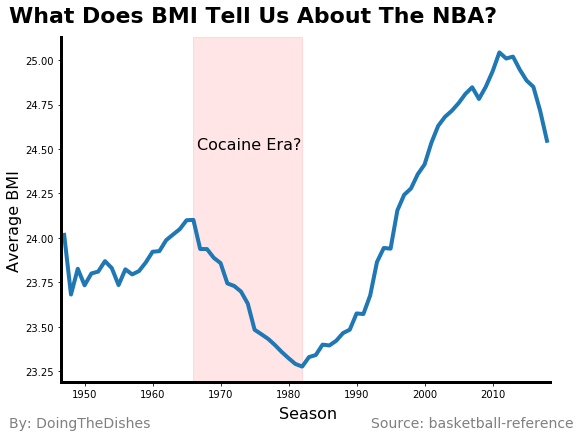

In [10]:
fig = plt.figure(figsize=(8,6))

fig.text(0.01,0.01,'By: DoingTheDishes',fontsize=14.0,color='gray',
         horizontalalignment='left',verticalalignment='bottom')
fig.text(0.99,0.01,'Source: basketball-reference',fontsize=14.0,color='gray',
         horizontalalignment='right',verticalalignment='bottom')


fig.text(0.01,0.99,"What Does BMI Tell Us About The NBA?",fontsize=22.0,
        horizontalalignment='left',weight="bold",verticalalignment='top')

fig.text(0.53,0.048,"Season",fontsize=16.0,color='black',
               horizontalalignment='center',verticalalignment='center')

fig.text(0.02,0.495,"Average BMI",fontsize=16.0,color='black',
               horizontalalignment='center',verticalalignment='center',rotation=90)

ax_left = 0.1
ax_bottom = 0.12
ax_width = 0.85
ax_height = 0.8
    

ax = fig.add_axes([ax_left,ax_bottom, ax_width, ax_height])

ax.plot(years.index,years.BMI,linewidth=4)
ax.set_xlim([1946.5,2018.5])
#ax.set_ylim([0.56,0.83])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(3.0)
ax.spines['bottom'].set_linewidth(3.0)

ylims = ax.get_ylim()
plt.fill_between([1966,1982,1982,1966],[ylims[0],ylims[0],ylims[1],ylims[1]],color='red',alpha=0.1)
ax.set_ylim(ylims)
plt.text(1966.5,24.5,'Cocaine Era?',fontsize=16);
plt.savefig('BMI.png',dpi=300,transparent=False,bbox_inches='tight')